# Population Inference on GWTC-1

The first gravitational-wave transient catalog ["GWTC-1"](https://arxiv.org/abs/1811.12907) includes all compact binary coalescences observed during Advanced LIGO/Virgo's first and second observing runs.

`GWPopulation` builds upon [bilby](https://git.ligo.org/lscsoft/bilby) ([arXiv:1811.02042](https://arxiv.org/abs/1811.02042)) to provide simple, modular, user-friendly, population inference.

There are many [implemented models](https://colmtalbot.github.io/gwpopulation/_autosummary/gwpopulation.models.html#module-gwpopulation.models) and an example of defining custom models is included below.
In this example we use:

- A mass distribution in primary mass and mass ratio from Talbot & Thrane (2018) ([arXiv:1801:02699](https://arxiv.org/abs/1801.02699)). This is equivalent to the `PowerLaw + Peak` model used in LVK analyses without the low-mass smoothing for computational efficiency.
- Half-Gaussian + isotropic spin tilt distribution from Talbot & Thrane (2017) ([arXiv:1704.08370](https://arxiv.org/abs/1704.08370)).
- Beta spin magnitude distribution from Wysocki+ (2018) ([arXiv:1805:06442](https://arxiv.org/abs/1805.06442)).
- Each of these are also available with independent but identically distributed spins.
- Redshift evolution model as in Fishbach+ (2018) ([arXiv:1805.10270](https://arxiv.org/abs/1805.10270)).

For more information see the [git repository](https://github.com/ColmTalbot/gwpopulation), [documentation](https://colmtalbot.github.io/gwpopulation/).


## Install some packages

- `gwpopulation` has the population model code.
- `nestle` is a sampler that runs quickly for simple problems, but may not give publication quality results.

If you're using colab.research.google.com you will want to choose a GPU-accelerated runtime.

"runtime"->"change runtime type"->"Hardware accelerator = GPU"

In [1]:
!pip install gwpopulation nestle --quiet --progress-bar off

## Get the data

Pull the posterior samples for each of the events from the [LIGO dcc](https://dcc.ligo.org).

In [2]:
!wget https://dcc.ligo.org/public/0157/P1800370/002/GWTC-1_sample_release.tar.gz
!tar -xvzf GWTC-1_sample_release.tar.gz

--2024-06-14 15:11:15--  https://dcc.ligo.org/public/0157/P1800370/002/GWTC-1_sample_release.tar.gz
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89895447 (86M) [application/x-gzip]
Saving to: ‘GWTC-1_sample_release.tar.gz’

GWTC-1_sample_relea 100%[===================>]  85.73M  3.49MB/s    in 23s     

2024-06-14 15:11:38 (3.68 MB/s) - ‘GWTC-1_sample_release.tar.gz’ saved [89895447/89895447]

x ./GWTC-1_sample_release/
x ./GWTC-1_sample_release/GW170729_GWTC-1.hdf5
x ./GWTC-1_sample_release/GW151226_GWTC-1.hdf5
x ./GWTC-1_sample_release/GW170809_GWTC-1.hdf5
x ./GWTC-1_sample_release/GW170104_GWTC-1.hdf5
x ./GWTC-1_sample_release/GW170817_GWTC-1.hdf5
x ./GWTC-1_sample_release/GW170608_GWTC-1.hdf5
x ./GWTC-1_sample_release/GW170814_GWTC-1.hdf5
x ./GWTC-1_sample_release/GW151012_GWTC-1.hdf5
x ./GWTC-1_sample_release/GW170809_priorChoices_GWTC-1.h

## Imports

Import the packages required for the script.
We also set the backend for array operations to `jax` which allows us to take advantage of just-in-time (jit) compilation in addition to GPU parallelisation when available.

In [3]:
import bilby as bb
import gwpopulation as gwpop
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bilby.core.prior import LogUniform, PriorDict, Uniform
from gwpopulation.experimental.jax import JittedLikelihood, NonCachingModel
from wcosmo import z_at_value, Planck15

gwpop.set_backend("jax")

xp = gwpop.utils.xp

%matplotlib inline

## Load posteriors

We're using the posteriors from the GWTC-1 data release.

We need to change the names of the parameters to make them work with the code.

In [4]:
parameter_translator = dict(
    mass_1_det="m1_detector_frame_Msun",
    mass_2_det="m2_detector_frame_Msun",
    luminosity_distance="luminosity_distance_Mpc",
    a_1="spin1",
    a_2="spin2",
    cos_tilt_1="costilt1",
    cos_tilt_2="costilt2",
)

posteriors = list()
priors = list()

file_str = "./GWTC-1_sample_release/GW{}_GWTC-1.hdf5"

events = [
    "150914",
    "151012",
    "151226",
    "170104",
    "170608",
    "170729",
    "170809",
    "170814",
    "170818",
    "170823",
]
for event in events:
    _posterior = pd.DataFrame()
    _prior = pd.DataFrame()
    with h5py.File(file_str.format(event)) as ff:
        for my_key, gwtc_key in parameter_translator.items():
            _posterior[my_key] = ff["IMRPhenomPv2_posterior"][gwtc_key]
            _prior[my_key] = ff["prior"][gwtc_key]
    posteriors.append(_posterior)
    priors.append(_prior)

## Add some weights to posterior

Make sure the posterior `DataFrames` contain the appropriate quantities.

We could include a `prior` column, this is the prior used in the initial sampling stage.
This is used to weight the samples in the likelihood.

In [5]:
for posterior in posteriors:
    posterior["redshift"] = z_at_value(
        Planck15.luminosity_distance, posterior["luminosity_distance"]
    )
    posterior["mass_1"] = posterior["mass_1_det"] / (1 + posterior["redshift"])
    posterior["mass_2"] = posterior["mass_2_det"] / (1 + posterior["redshift"])
    posterior["mass_ratio"] = posterior["mass_2"] / posterior["mass_1"]

## Specify the model

Choose which population models we want to use.

For the mass distribution we use

`gwpopulation.models.mass.two_component_primary_mass_ratio`.

This is a powerlaw + Gaussian mass distribution with powerlaw mass ratio distribution.

For spins we use

`gwpopulation.models.spin.iid_spin`

Where the spins of the two black holes are independently and identically distributed with a beta distribution for the magnitude and an isotropic + half-Gaussian for the cosine tilts.


**Note:** We use the `gwpopulation.experimental.jax.NonCachingModel` as internal caching breaks the JIT functionality.

In [6]:
model = NonCachingModel(
    [
        gwpop.models.mass.two_component_primary_mass_ratio,
        gwpop.models.spin.iid_spin,
    ]
)

## Selection effects

Gravitational-wave surveys suffer from Malmquist bias.

In order to measure the true, astrophysical, distribution we must include a term to account for this in our population analyses.

The way the likelihood is structured, this can be any object that evaluates to give the observed spactime volume as a function of the population parameters.

We define classes so that various bits of metadata can be stored.

The data for calculating this is not easily available.
We use a very rough toy model to get the general scaling for the primary mass, $VT(m) \sim m^{1.6}$.
This value was chosen to get a decent agreement with the more complex model.

**I do not recommend using this toy function for science.**

In [7]:
def toy_vt_calculator(kwargs):
    masses = xp.linspace(3, 100, 1000)
    vts = masses**1.6
    params = {
        key: kwargs[key]
        for key in [
            "alpha",
            "mmin",
            "mmax",
            "lam",
            "mpp",
            "sigpp",
            "gaussian_mass_maximum",
        ]
    }
    p_m = gwpop.models.mass.two_component_single(masses, **params)
    return xp.trapz(p_m * vts, masses)

## Define the likelihood

The `HyperparameterLikelihood` marginalises over the local merger rate, with a uniform-in-log prior.

To also estimate the rate use the `RateLikelilhood` (see further on in the notebook).

We provide:

- `posteriors`: a list of `pandas` DataFrames
- `hyper_prior`: our population model, as defined above
- `selection_function`: anything which evaluates the selection function

We can also provide:

- `conversion_function`: this converts between the parameters we sample in and those needed by the model, e.g., for sampling in the mean and variance of the beta distribution
- `max_samples`: the maximum number of samples to use from each posterior, this defaults to the length of the shortest posterior.

In [8]:
fast_likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=model,
    selection_function=toy_vt_calculator,
)

15:11 bilby INFO    : No prior values provided, defaulting to 1.


## Define the prior

This is the standard method to define the prior distribution within `Bilby`.

The labels are used in plotting.
Numbers are converted to delta function priors and are not sampled.

There are many other distributions available, see the `Bilby` docs for a more comprehensize list.

In [9]:
fast_priors = PriorDict()

# mass
fast_priors["alpha"] = Uniform(minimum=-2, maximum=4, latex_label="$\\alpha$")
fast_priors["beta"] = Uniform(minimum=-4, maximum=12, latex_label="$\\beta$")
fast_priors["mmin"] = Uniform(minimum=5, maximum=10, latex_label="$m_{\\min}$")
fast_priors["mmax"] = Uniform(minimum=20, maximum=60, latex_label="$m_{\\max}$")
fast_priors["lam"] = Uniform(minimum=0, maximum=1, latex_label="$\\lambda_{m}$")
fast_priors["mpp"] = Uniform(minimum=10, maximum=50, latex_label="$\\mu_{m}$")
fast_priors["sigpp"] = Uniform(minimum=1, maximum=10, latex_label="$\\sigma_{m}$")
fast_priors["gaussian_mass_maximum"] = 100
# spin
fast_priors["amax"] = 1
fast_priors["alpha_chi"] = Uniform(
    minimum=1, maximum=6, latex_label="$\\alpha_{\\chi}$"
)
fast_priors["beta_chi"] = Uniform(minimum=1, maximum=6, latex_label="$\\beta_{\\chi}$")
fast_priors["xi_spin"] = Uniform(minimum=0, maximum=1, latex_label="$\\xi$")
fast_priors["sigma_spin"] = Uniform(minimum=0, maximum=4, latex_label="$\\sigma$")

## Just-in-time compile

We JIT compile the likelihood object before starting the sampler.
This is done using the `gwpopulation.experimental.jax.JittedLikelihood` class.

We then time the original likelihood object and the JIT-ed version.
Note that we do two evaluations for each object as the first evaluation must compile the likelihood and so takes longer. (In addition to the JIT compilation, `JAX` compiles GPU functionality at the first evaluation, but this is less extreme than the full JIT compilation.)

In [10]:
parameters = fast_priors.sample()
fast_likelihood.parameters.update(parameters)
fast_likelihood.log_likelihood_ratio()
%time print(fast_likelihood.log_likelihood_ratio())
jit_likelihood = JittedLikelihood(fast_likelihood)
jit_likelihood.parameters.update(parameters)
%time print(jit_likelihood.log_likelihood_ratio())
%time print(jit_likelihood.log_likelihood_ratio())

-122.92178493555657
CPU times: user 28.8 ms, sys: 7.99 ms, total: 36.8 ms
Wall time: 13.3 ms
-122.92178493555659
CPU times: user 294 ms, sys: 29.5 ms, total: 323 ms
Wall time: 267 ms
-122.92178493555659
CPU times: user 15.2 ms, sys: 123 µs, total: 15.3 ms
Wall time: 3.56 ms


## Run the sampler

We'll use the sampler `nestle` and use a small number of live points to reduce the runtime.
This sampler is fast, but can produce unreliable results.
Any of samplers available available through `Bilby` can be used and the convergence properties of any sampler should be understood before publishing.

This is slower without using the GPU version, but the JIT makes it bearable.

`Bilby` times a single likelihood evaluation before beginning the run, however, this isn't well defined with JAX.

**Note:** sometimes this finds a high likelihood mode, likely due to [breakdowns in the approximation](https://arxiv.org/abs/2304.06138) used to estimate the likelihood. If you see `dlogz > -80`, you should interrupt the execution and restart.

In [11]:
fast_result = bb.run_sampler(
    likelihood=jit_likelihood,
    priors=fast_priors,
    sampler="nestle",
    nlive=100,
    label="fast",
    save="hdf5",
)

15:11 bilby INFO    : Running for label 'fast', output will be saved to 'outdir'
15:11 bilby INFO    : Analysis priors:
15:11 bilby INFO    : alpha=Uniform(minimum=-2, maximum=4, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
15:11 bilby INFO    : beta=Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\beta$', unit=None, boundary=None)
15:11 bilby INFO    : mmin=Uniform(minimum=5, maximum=10, name=None, latex_label='$m_{\\min}$', unit=None, boundary=None)
15:11 bilby INFO    : mmax=Uniform(minimum=20, maximum=60, name=None, latex_label='$m_{\\max}$', unit=None, boundary=None)
15:11 bilby INFO    : lam=Uniform(minimum=0, maximum=1, name=None, latex_label='$\\lambda_{m}$', unit=None, boundary=None)
15:11 bilby INFO    : mpp=Uniform(minimum=10, maximum=50, name=None, latex_label='$\\mu_{m}$', unit=None, boundary=None)
15:11 bilby INFO    : sigpp=Uniform(minimum=1, maximum=10, name=None, latex_label='$\\sigma_{m}$', unit=None, boundary=None)
15:11 bilby INFO    : alp

it=   739 logz=-97.9063429000000052504760255204420248704468581108159154915854115511802457988908195786371375080447864043704443832883878176942523235360430575644792184786706982848387200926575803737830233794788090059368953234970799945081119038967640880074652742780142494579258788820056842838115669472196386865459400540160.000000

15:11 bilby INFO    : Sampling time: 0:00:13.002211


15:11 bilby INFO    : Summary of results:
nsamples: 840
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.179
ln_bayes_factor: -97.729 +/-  0.179



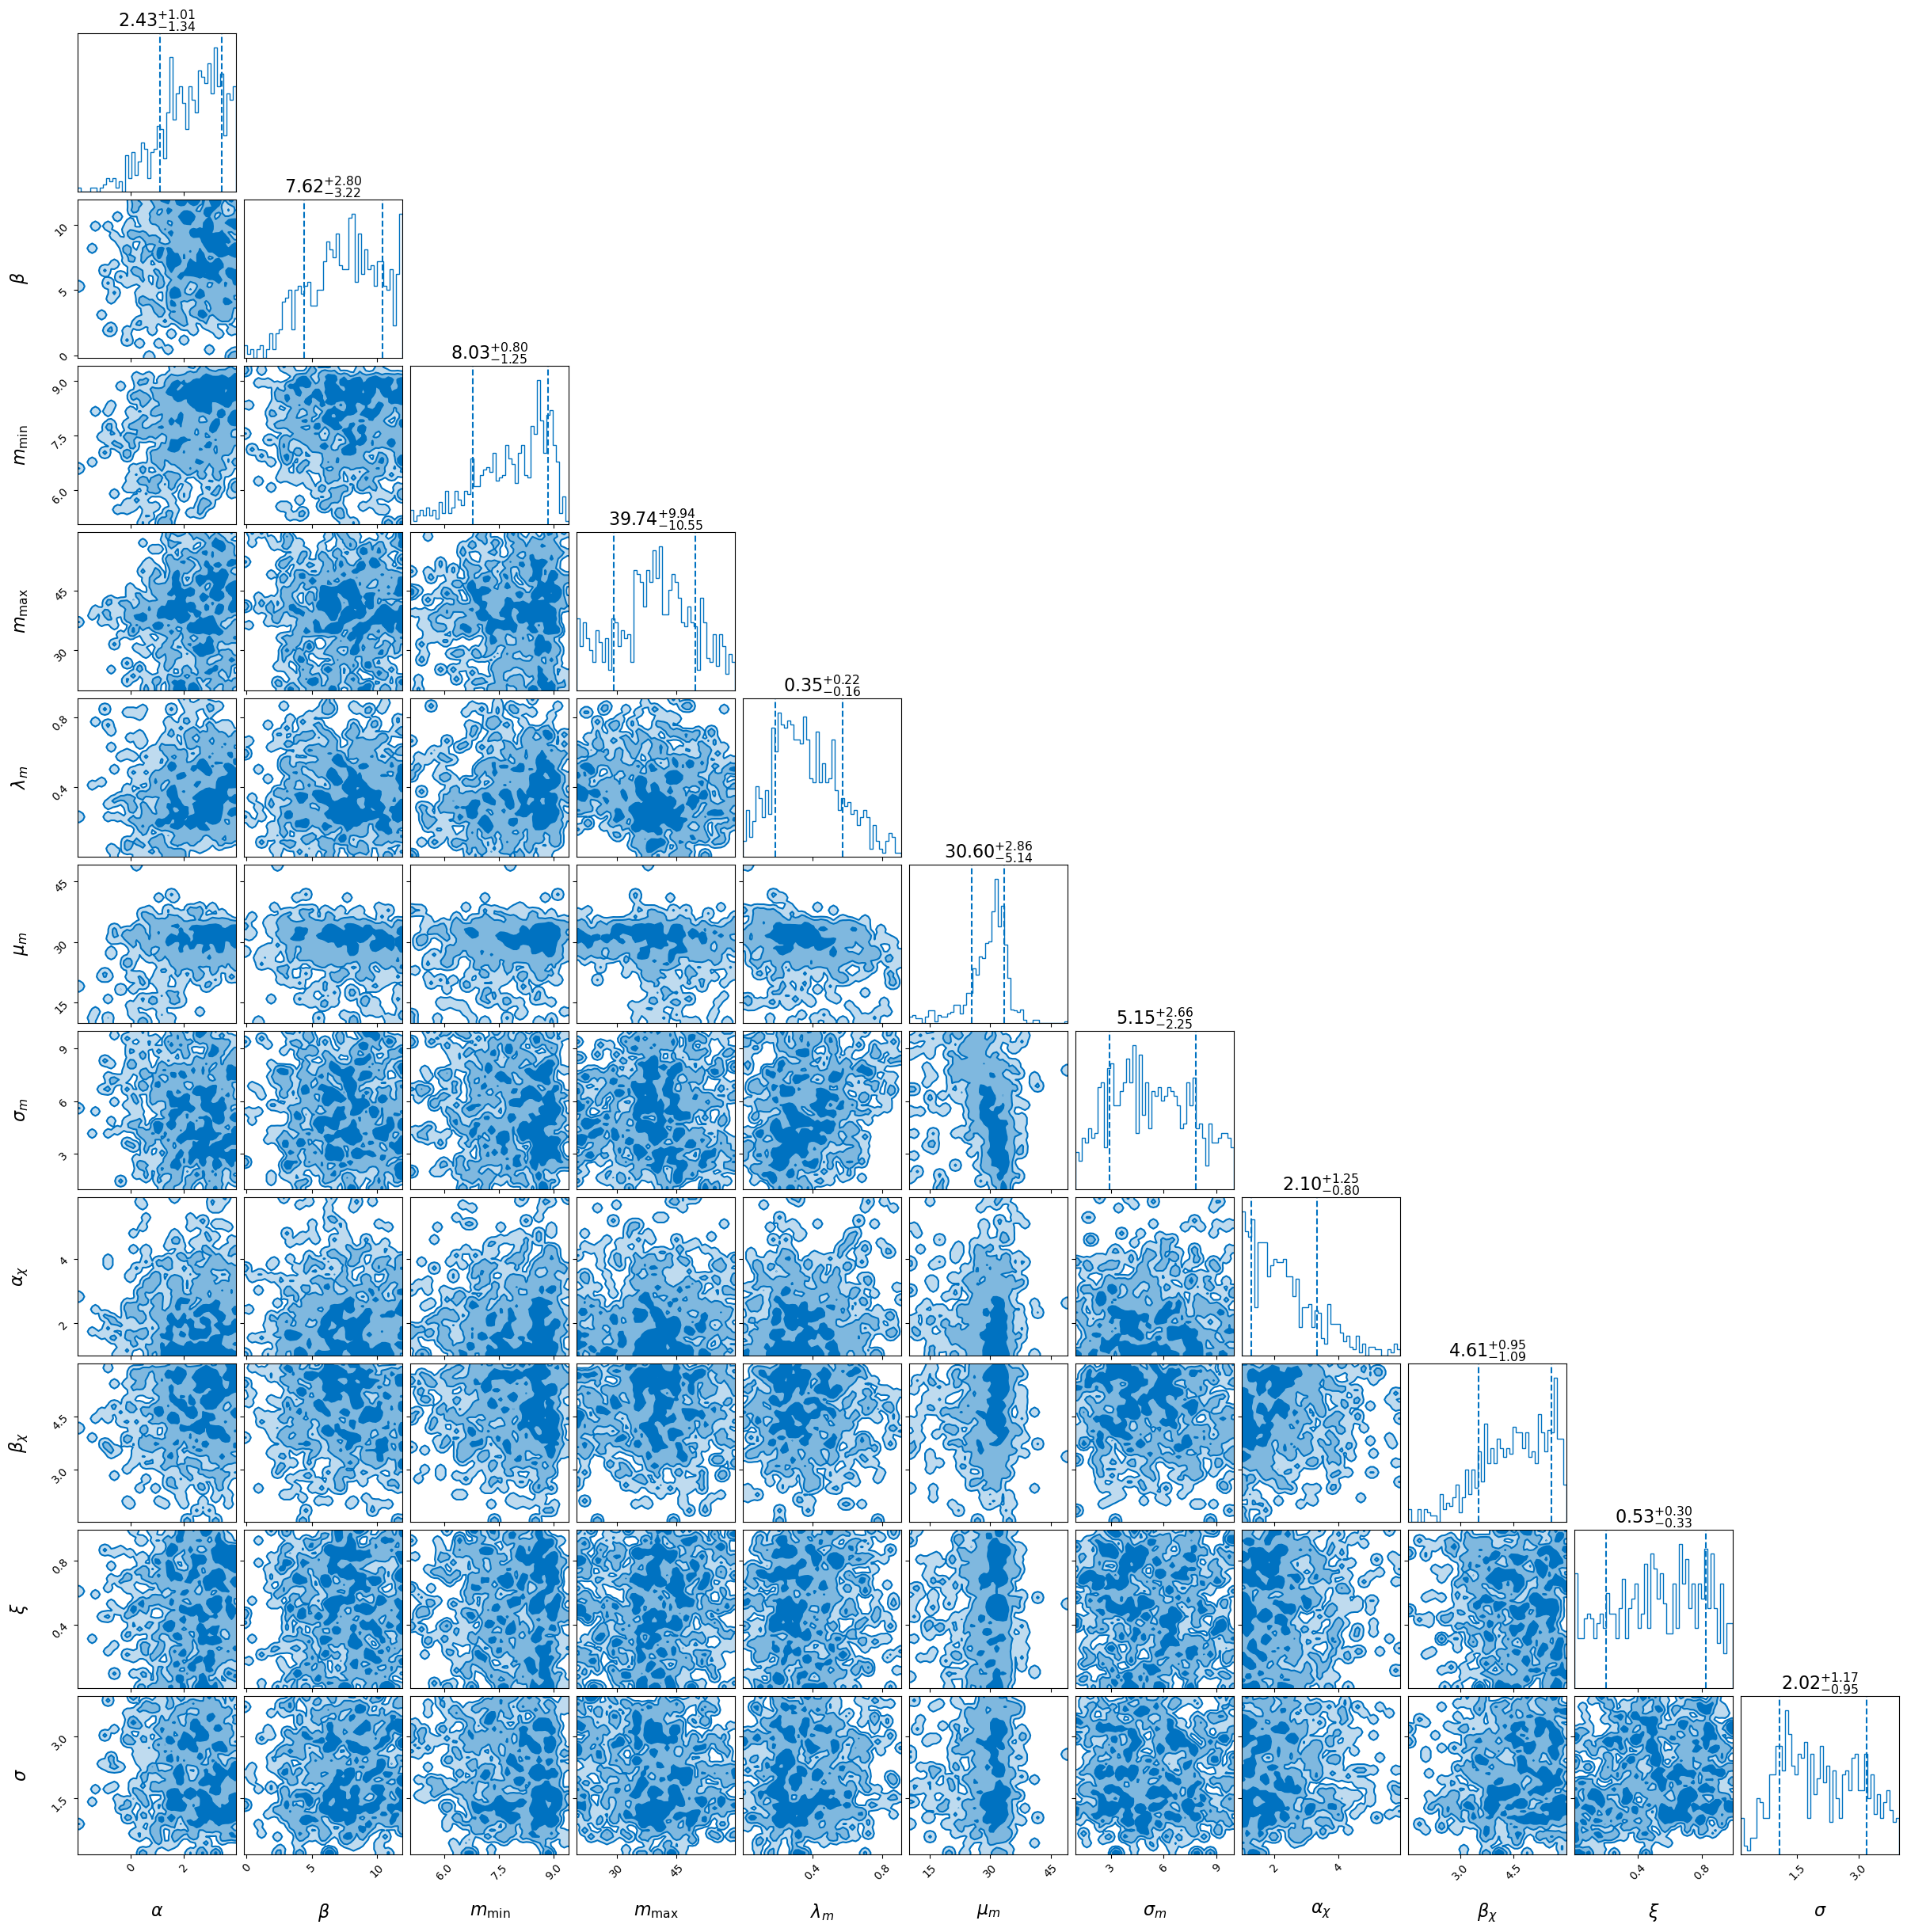

In [12]:
_ = fast_result.plot_corner(save=False)

We can compute a rate posterior as a post-processing step.
Note that because we used the unphysical selection function above, this is not going to be a sensible number.
We also use the non-JIT-compiled likelihood for this stage.

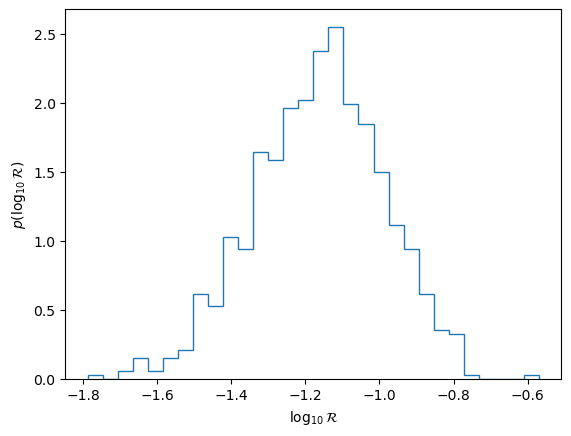

In [13]:
rates = list()
for ii in range(len(fast_result.posterior)):
    fast_likelihood.parameters.update(dict(fast_result.posterior.iloc[ii]))
    rates.append(float(fast_likelihood.generate_rate_posterior_sample()))
fast_result.posterior["rate"] = rates

plt.hist(np.log10(rates), bins=30, histtype="step", density=True)
plt.xlabel("$\\log_{10} {\\cal R}$")
plt.ylabel("$p(\\log_{10} {\\cal R})$")
plt.show()
plt.close()

## Define a new model

### Let's define a new population model for BNS.

Just as an example we'll use a Gaussian distribution bounded between $[1 M_{\odot}, 2 M_{\odot}]$.

$$p(m_1, m_2) = N \exp \left(- \frac{\left((m_1 - \mu)^2 + (m_2 - \mu)^2\right)}{2 \sigma^2}\right) \quad : \quad 1 \leq m_2 \leq m_1 \leq 2$$

We see that this function takes three arguments:

- `dataset`: this is common to all of the population models in `gwpopulation`, it is a dictionary containing the data to be evaluated, here it is assumed to contain entries for `mass_1` and `mass_2`, the _source-frame_ masses.
- `mu_bns`: the peak of the bns mass distribution.
- `sigma_bns`: the width of the bns mass distribution.

In [14]:
def truncated_gaussian_primary_secondary_identical(dataset, mu_bns, sigma_bns):
    prob = gwpop.utils.truncnorm(
        dataset["mass_1"], mu=mu_bns, sigma=sigma_bns, low=1, high=2
    )
    prob *= gwpop.utils.truncnorm(
        dataset["mass_2"], mu=mu_bns, sigma=sigma_bns, low=1, high=2
    )
    prob *= dataset["mass_1"] >= dataset["mass_2"]
    prob *= 2
    return prob

## Load GW170817 posterior

This is just the same as above.

In [15]:
posterior = pd.DataFrame()
prior = pd.DataFrame()
with h5py.File("./GWTC-1_sample_release/GW170817_GWTC-1.hdf5") as ff:
    for my_key, gwtc_key in parameter_translator.items():
        try:
            posterior[my_key] = ff["IMRPhenomPv2NRT_lowSpin_posterior"][gwtc_key]
            prior[my_key] = ff["IMRPhenomPv2NRT_lowSpin_prior"][gwtc_key]
        except ValueError:
            pass

posterior["redshift"] = z_at_value(
    Planck15.luminosity_distance, posterior["luminosity_distance"]
)
posterior["mass_1"] = posterior["mass_1_det"] / (1 + posterior["redshift"])
posterior["mass_2"] = posterior["mass_2_det"] / (1 + posterior["redshift"])

## Define the new likelihood

We use the same likelihood as before.

_Note_:

- This time we cast our posterior to a list while creating the likelihood.
- We pass the function rather than a `Model` object as before, `bilby` will turn this into a `Model` for internal use. This means that we cannot use JIT compilation, but that is fine as we are only analysing a single event.
- We've removed the selection and conversion functions as they aren't needed here (yes, a selection function is technically needed).

In [16]:
bns_likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=[posterior],
    hyper_prior=truncated_gaussian_primary_secondary_identical,
)

15:12 bilby INFO    : No prior values provided, defaulting to 1.


## Define the new prior

Just as before.

In [17]:
bns_priors = PriorDict()
bns_priors["mu_bns"] = Uniform(minimum=1, maximum=2, latex_label="$\\mu_{bns}$")
bns_priors["sigma_bns"] = LogUniform(
    minimum=1e-2, maximum=1, latex_label="$\\sigma_{bns}$"
)

In [18]:
bns_likelihood.parameters.update(bns_priors.sample())
bns_likelihood.log_likelihood_ratio()

bns_result = bb.run_sampler(
    likelihood=bns_likelihood,
    priors=bns_priors,
    sampler="nestle",
    nlive=100,
    label="bns",
    save="hdf5",
)

15:12 bilby INFO    : Running for label 'bns', output will be saved to 'outdir'
15:12 bilby INFO    : Analysis priors:
15:12 bilby INFO    : mu_bns=Uniform(minimum=1, maximum=2, name=None, latex_label='$\\mu_{bns}$', unit=None, boundary=None)
15:12 bilby INFO    : sigma_bns=LogUniform(minimum=0.01, maximum=1, name=None, latex_label='$\\sigma_{bns}$', unit=None, boundary=None)
15:12 bilby INFO    : Analysis likelihood class: <class 'gwpopulation.hyperpe.HyperparameterLikelihood'>
15:12 bilby INFO    : Analysis likelihood noise evidence: nan
15:12 bilby INFO    : Single likelihood evaluation took 8.970e-04 s
15:12 bilby INFO    : Using sampler Nestle with kwargs {'method': 'multi', 'npoints': 100, 'update_interval': None, 'npdim': None, 'maxiter': None, 'maxcall': None, 'dlogz': None, 'decline_factor': None, 'rstate': None, 'callback': <function print_progress at 0x363190550>, 'steps': 20, 'enlarge': 1.2}


it=   478 logz=0.471271366000000052504760255204420248704468581108159154915854115511802457988908195786371375080447864043704443832883878176942523235360430575644792184786706982848387200926575803737830233794788090059368953234970799945081119038967640880074652742780142494579258788820056842838115669472196386865459400540160.000000


15:12 bilby INFO    : Sampling time: 0:00:01.442531
15:12 bilby INFO    : Summary of results:
nsamples: 579
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.127
ln_bayes_factor:  0.747 +/-  0.127



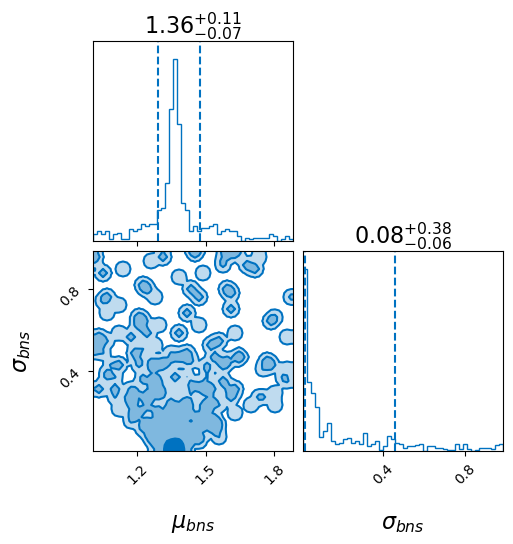

In [19]:
_ = bns_result.plot_corner(save=False)

## Do it all

Let's put together a run with models for the mass, spin and redshift distributions.

**This will not give sensible answers because VT is not estimated.**

Note that the redshift model is a class and so is called slightly differently.
This is to enable automatic estimation of cosmologolical parameters (not included here).

Once again, we are going to JIT compile the likelihood, and so we use the `NonCachingModel`.
The caching this disables is not the same as the redshift caching and so can be safely used.

In [20]:
full_model = NonCachingModel(
    [
        gwpop.models.mass.two_component_primary_mass_ratio,
        gwpop.models.spin.iid_spin_magnitude_beta,
        gwpop.models.spin.independent_spin_orientation_gaussian_isotropic,
        gwpop.models.redshift.PowerLawRedshift(),
    ]
)

## Update sampling prior

We need to update the sampling prior to account for the new redshift evolution model $\pi(z) = \pi(d_{L})\frac{dL}{dz}$.

In [21]:
for posterior in posteriors:
    posterior["prior"] = posterior["luminosity_distance"] ** 2 * Planck15.dDLdz(
        posterior["redshift"].values
    )

## Likelihood

This is created just as before.
We neglect selection effects for simplicity.

In [22]:
full_likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=posteriors, hyper_prior=full_model
)

## Prior

This is just a longer version of the previous.

In [23]:
full_priors = PriorDict()

# mass
full_priors["alpha"] = Uniform(minimum=-4, maximum=12, latex_label="$\\alpha$")
full_priors["beta"] = Uniform(minimum=-4, maximum=12, latex_label="$\\beta$")
full_priors["mmin"] = Uniform(minimum=5, maximum=10, latex_label="$m_{\\min}$")
full_priors["mmax"] = Uniform(minimum=20, maximum=60, latex_label="$m_{\\max}$")
full_priors["lam"] = Uniform(minimum=0, maximum=1, latex_label="$\\lambda_{m}$")
full_priors["mpp"] = Uniform(minimum=20, maximum=50, latex_label="$\\mu_{m}$")
full_priors["sigpp"] = Uniform(minimum=0, maximum=10, latex_label="$\\sigma_{m}$")
full_priors["gaussian_mass_maximum"] = 100
# spin magnitude
full_priors["amax"] = 1
full_priors["alpha_chi"] = Uniform(
    minimum=1, maximum=4, latex_label="$\\alpha_{\\chi}$"
)
full_priors["beta_chi"] = Uniform(minimum=1, maximum=4, latex_label="$\\beta_{\\chi}$")
# spin orientation
full_priors["xi_spin"] = Uniform(minimum=0, maximum=1, latex_label="$\\xi$")
full_priors["sigma_1"] = Uniform(minimum=0, maximum=4, latex_label="$\\sigma{1}$")
full_priors["sigma_2"] = Uniform(minimum=0, maximum=4, latex_label="$\\sigma{2}$")
# redshift evolution
full_priors["lamb"] = Uniform(minimum=-25, maximum=25, latex_label="$\\lambda_{z}$")

In [24]:
full_likelihood.parameters.update(full_priors.sample())
full_likelihood.log_likelihood_ratio()
jit_likelihood = JittedLikelihood(full_likelihood)
jit_likelihood.parameters.update(full_priors.sample())
_ = jit_likelihood.log_likelihood_ratio()

Finally, we run the sampler just as before.

15:12 bilby INFO    : Running for label 'full', output will be saved to 'outdir'
15:12 bilby INFO    : Analysis priors:
15:12 bilby INFO    : alpha=Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
15:12 bilby INFO    : beta=Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\beta$', unit=None, boundary=None)
15:12 bilby INFO    : mmin=Uniform(minimum=5, maximum=10, name=None, latex_label='$m_{\\min}$', unit=None, boundary=None)
15:12 bilby INFO    : mmax=Uniform(minimum=20, maximum=60, name=None, latex_label='$m_{\\max}$', unit=None, boundary=None)
15:12 bilby INFO    : lam=Uniform(minimum=0, maximum=1, name=None, latex_label='$\\lambda_{m}$', unit=None, boundary=None)
15:12 bilby INFO    : mpp=Uniform(minimum=20, maximum=50, name=None, latex_label='$\\mu_{m}$', unit=None, boundary=None)
15:12 bilby INFO    : sigpp=Uniform(minimum=0, maximum=10, name=None, latex_label='$\\sigma_{m}$', unit=None, boundary=None)
15:12 bilby INFO    : al

it=   919 logz=-256.085814000000052504760255204420248704468581108159154915854115511802457988908195786371375080447864043704443832883878176942523235360430575644792184786706982848387200926575803737830233794788090059368953234970799945081119038967640880074652742780142494579258788820056842838115669472196386865459400540160.000000


15:12 bilby INFO    : Sampling time: 0:00:19.030605
15:12 bilby INFO    : Summary of results:
nsamples: 1020
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.227
ln_bayes_factor: -255.889 +/-  0.227



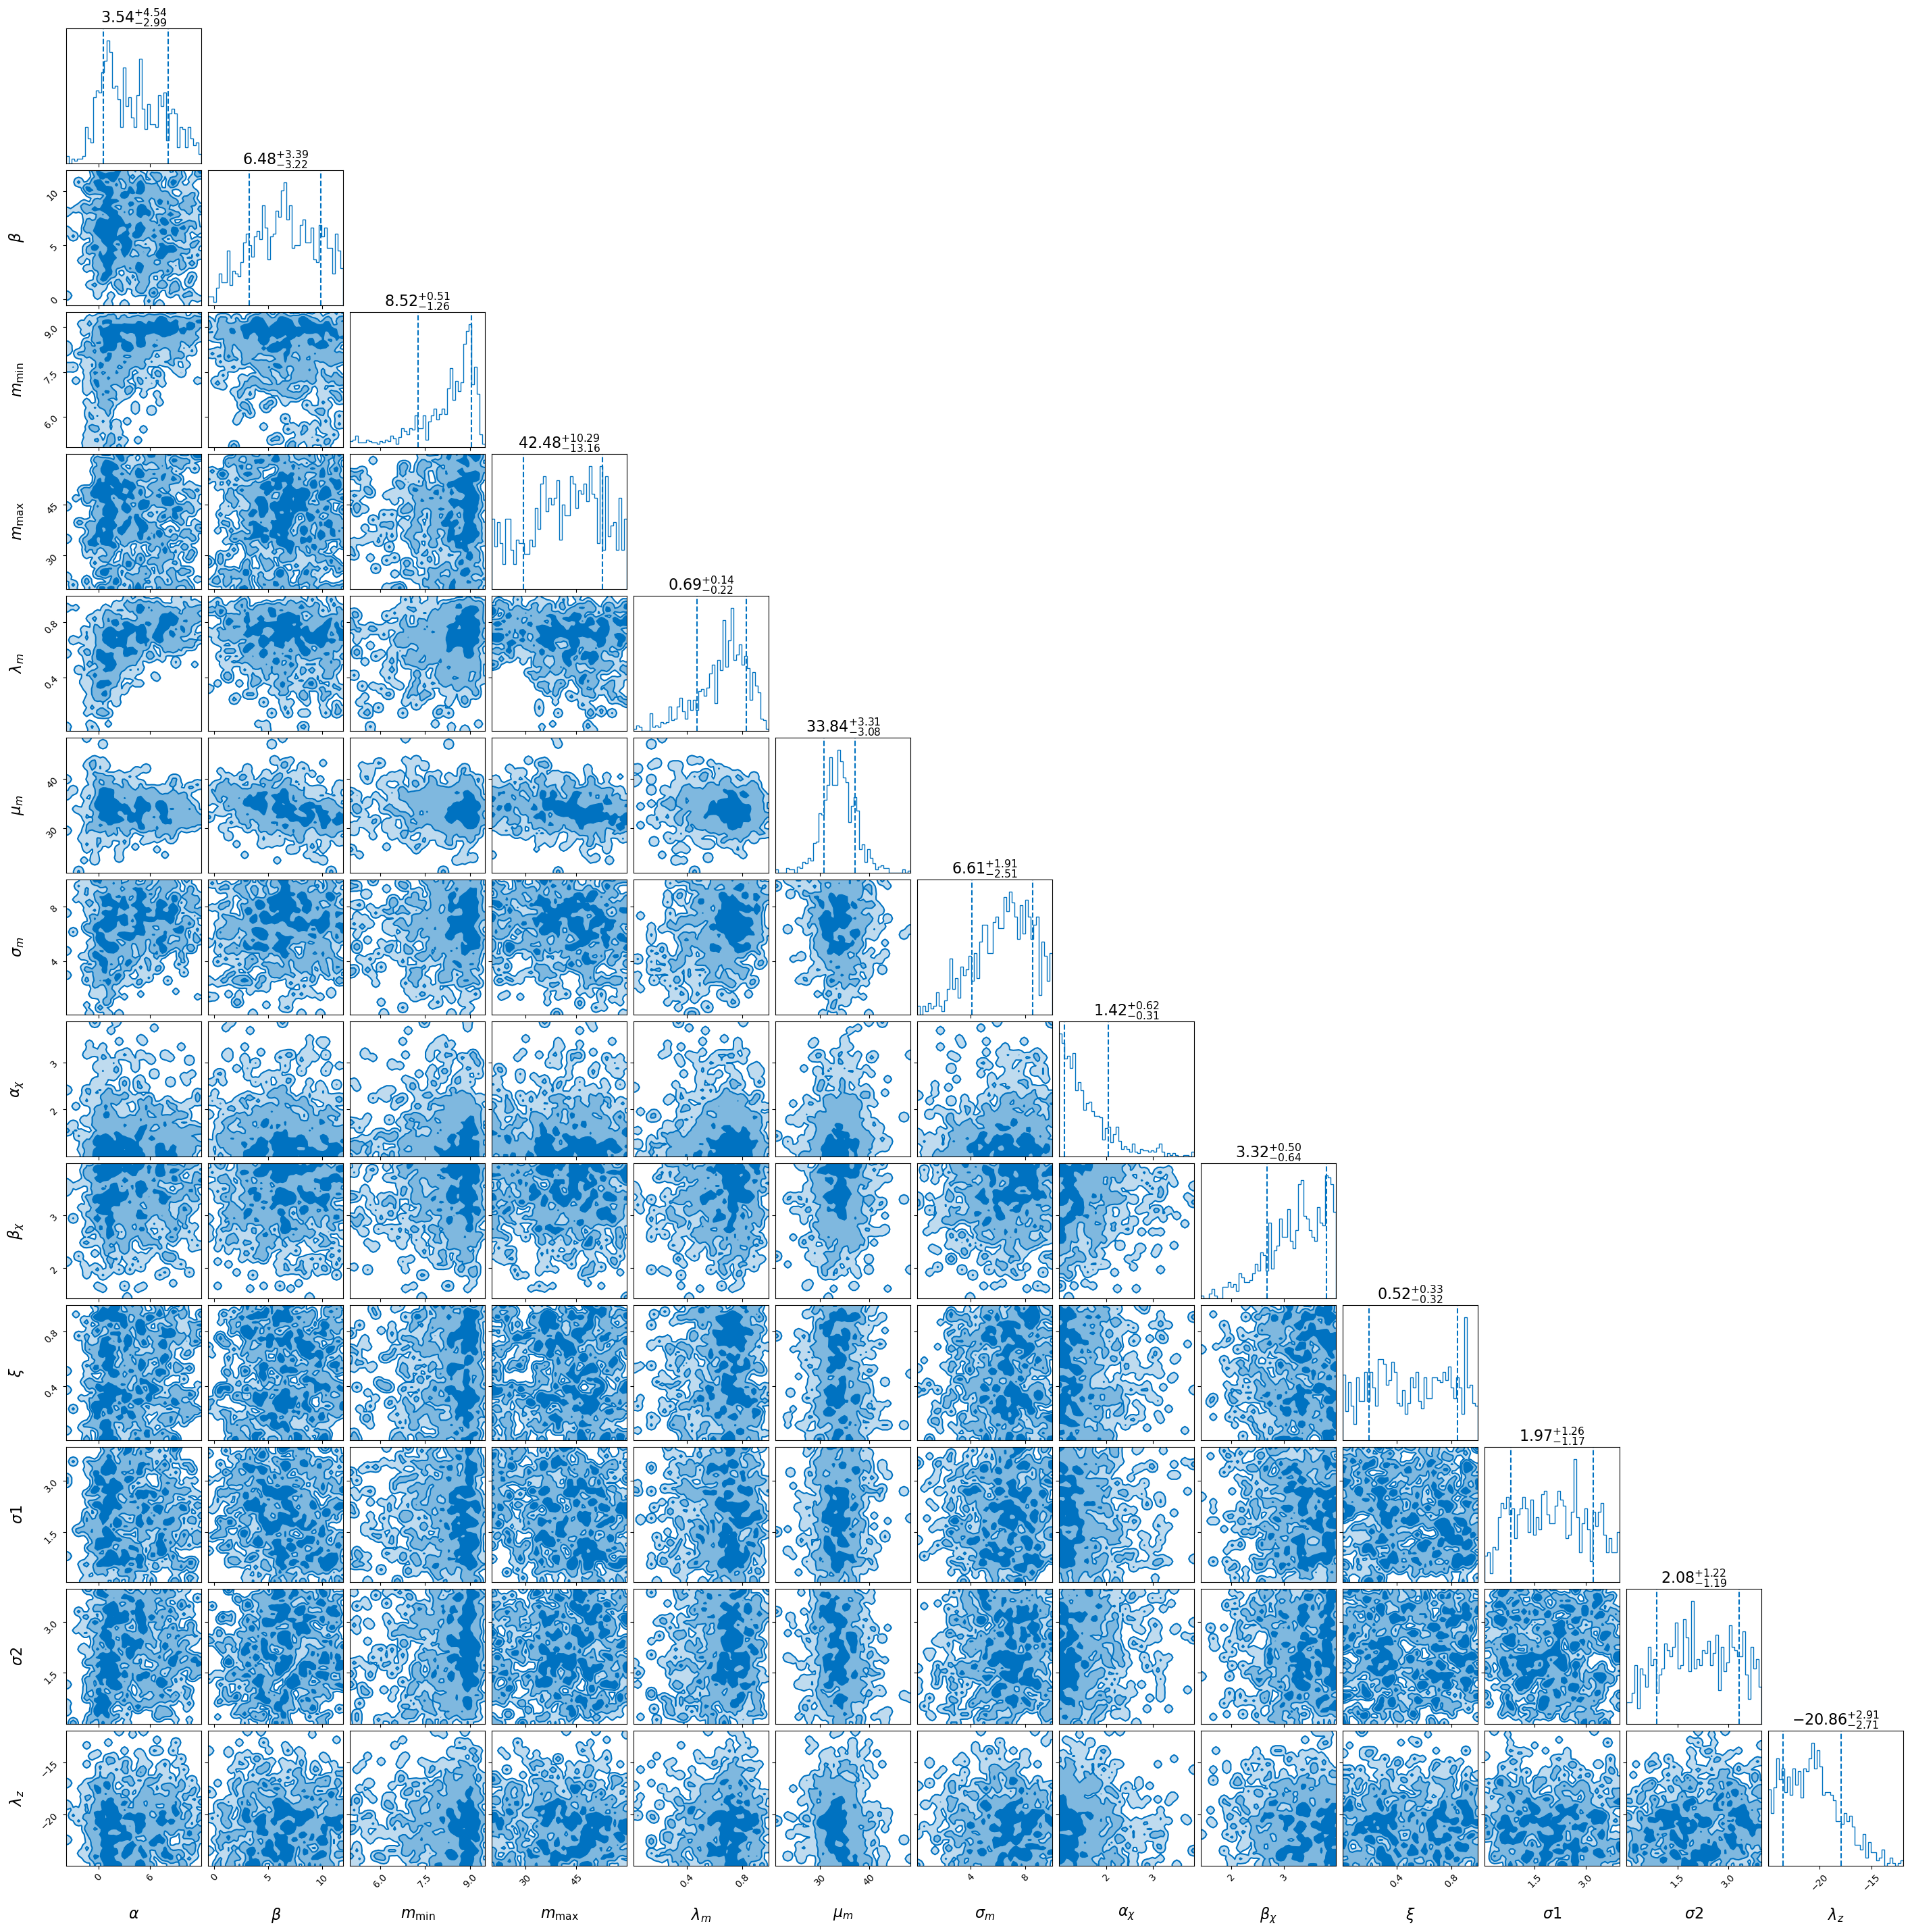

In [25]:
full_result = bb.run_sampler(
    likelihood=jit_likelihood,
    priors=full_priors,
    sampler="nestle",
    nlive=100,
    label="full",
    save="hdf5",
)

_ = full_result.plot_corner(save=False)